## Tools

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss

sns.set_style("darkgrid")

## Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data = pd.read_csv("BreastCancerData.csv")
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


## Basic EDA

<Axes: >

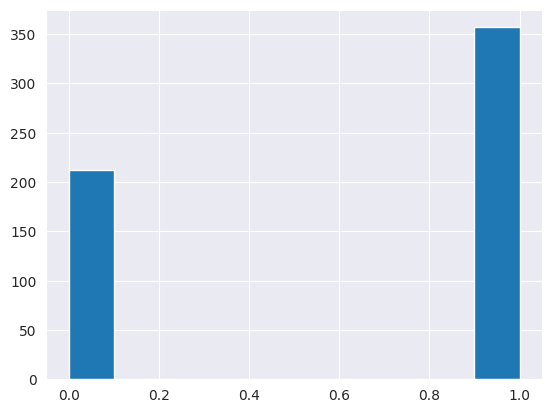

In [ ]:
data["diagnosis"].hist()

<Axes: >

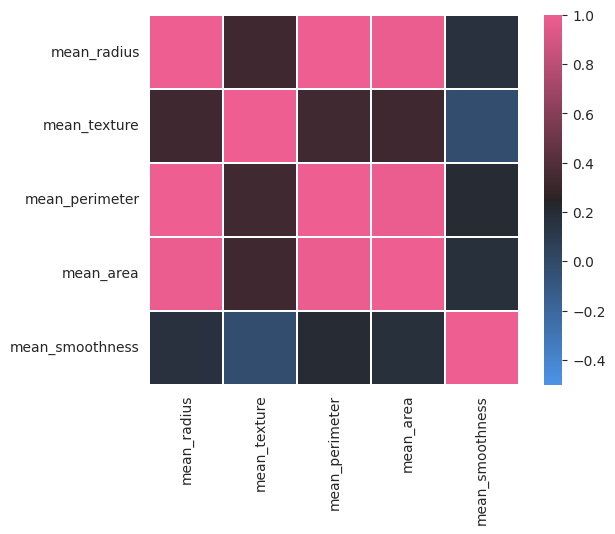

In [ ]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [ ]:
data = data[["mean_radius", "mean_texture", "mean_smoothness", "diagnosis"]]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


<Axes: xlabel='mean_texture', ylabel='Count'>

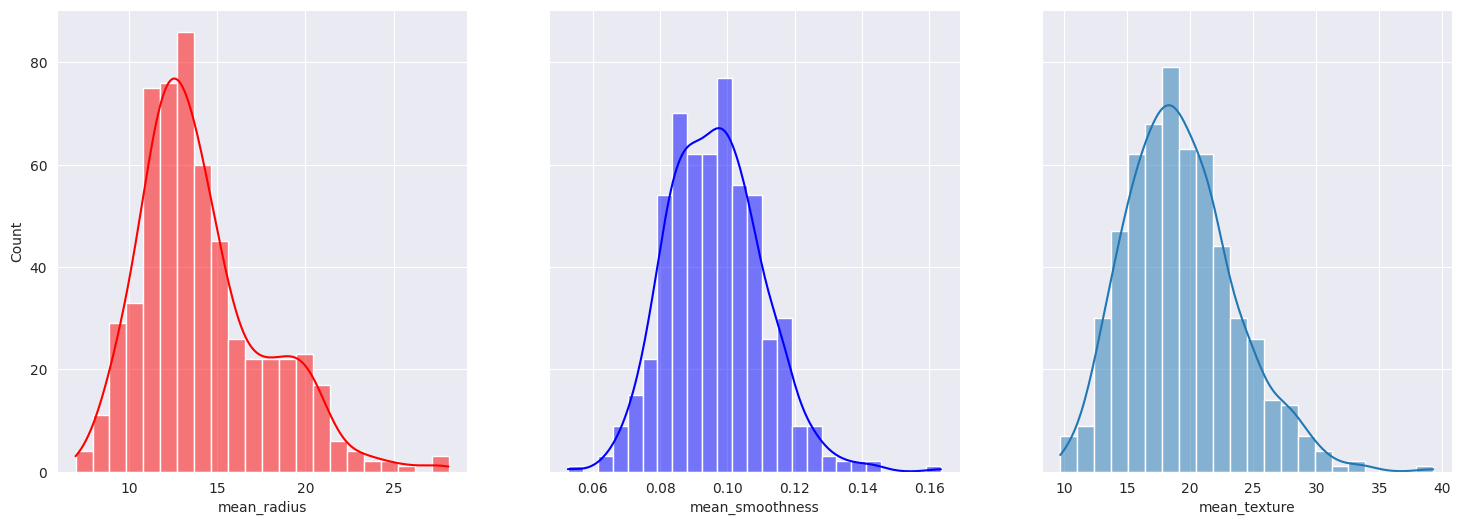

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)


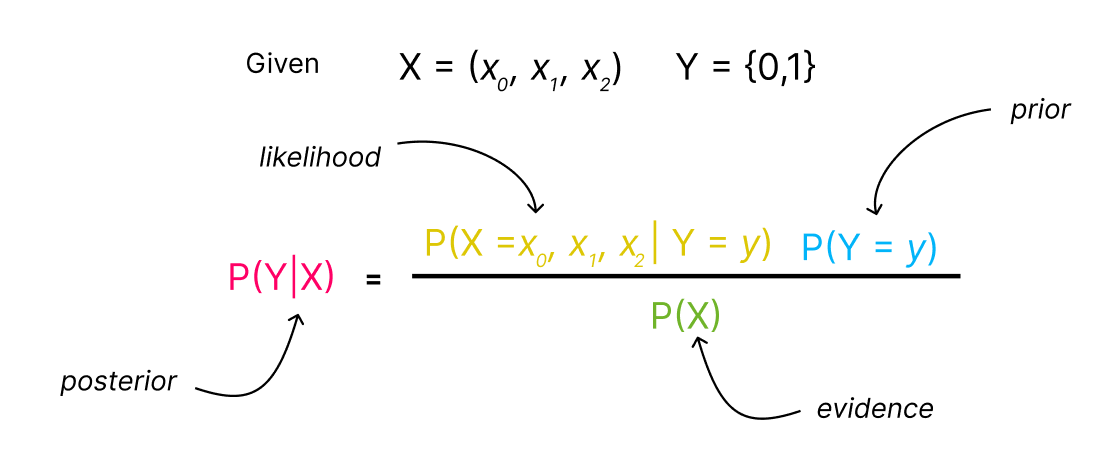

## Calculate P(Y=y) for all possible y

---



In [ ]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [ ]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [ ]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

# Calculating and Returning Prediction Probability

In [ ]:
def naive_bayes_gaussian_prob(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_prob = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        # calculate probability estimates (normalize by the sum of posteriors)
        prob = post_prob / np.sum(post_prob)
        Y_prob.append(prob)

    return np.array(Y_prob)

## Test Gaussian model

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


what does means 0? false negative ... and what about 4? false positive

In [ ]:
Y_proba = naive_bayes_gaussian_prob(train, X=X_test, Y="diagnosis")[:,1]

# Implementation of Accuracy


In [ ]:
def calculate_accuracy(y_true, y_pred):
    # Ensure that the lengths of y_true and y_pred are the same
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred must be the same.")

    # Count the number of correctly predicted labels
    correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)

    # Calculate accuracy
    accuracy = correct_predictions / len(y_true)

    return accuracy

In [ ]:
accuracy_score_calculation = calculate_accuracy(Y_test, Y_pred)

In [ ]:
print("Accuracy: " + str(accuracy_score_calculation))

Accuracy: 0.9649122807017544


# Implementation of Confusion Matrix

In [ ]:
def calculate_confusion_matrix(y_true, y_pred, num_classes=None):
    # If num_classes is not provided, infer it from y_true and y_pred
    if num_classes is None:
        num_classes = max(max(y_true), max(y_pred)) + 1

    # Initialize confusion matrix
    confusion = np.zeros((num_classes, num_classes), dtype=int)

    # Fill confusion matrix
    for true, pred in zip(y_true, y_pred):
        confusion[true][pred] += 1

    return confusion

In [ ]:
print("Confusion Matrix: \n" + str(calculate_confusion_matrix(Y_test, Y_pred)))

Confusion Matrix: 
[[36  4]
 [ 0 74]]


#Implementation of Precision

In [ ]:
def calculate_precision(y_true, y_pred, positive_label=1):


    true_positive = sum(1 for true, pred in zip(y_true, y_pred) if true == pred == positive_label)
    false_positive = sum(1 for true, pred in zip(y_true, y_pred) if true != pred and pred == positive_label)

    if true_positive + false_positive == 0:
        return 0.0

    precision = true_positive / (true_positive + false_positive)
    return precision

In [ ]:
print("Precision: " + str(calculate_precision(Y_test, Y_pred)))

Precision: 0.9487179487179487


# Implementation of Recall

In [ ]:
def calculate_recall(y_true, y_pred, positive_label=1):

    true_positive = sum(1 for true, pred in zip(y_true, y_pred) if true == pred == positive_label)
    false_negative = sum(1 for true, pred in zip(y_true, y_pred) if true != pred and true == positive_label)

    if true_positive + false_negative == 0:
        return 0.0

    recall = true_positive / (true_positive + false_negative)
    return recall

In [ ]:
print("Recall: " + str(calculate_recall(Y_test, Y_pred)))

Recall: 1.0


#Implementatio of F1 Score

In [ ]:
def calculate_f1_score(y_true, y_pred, positive_label=1):

    # Calculate precision
    precision_val = calculate_precision(y_true, y_pred, positive_label)

    # Calculate recall
    recall_val = calculate_recall(y_true, y_pred, positive_label)

    # Avoid division by zero
    if precision_val + recall_val == 0:
        return 0.0

    # Calculate F1 score
    f1 = 2 * (precision_val * recall_val) / (precision_val + recall_val)

    return f1

In [ ]:
print("F1 Score: " + str(calculate_f1_score(Y_test, Y_pred)))

F1 Score: 0.9736842105263158


#Implementation of ROC

In [ ]:
def calculate_roc_curve(y_true, y_score):

    # Combine true labels and predicted scores into tuples
    combined = list(zip(y_true, y_score))
    # Sort the combined list by predicted score in descending order
    combined_sorted = sorted(combined, key=lambda x: x[1], reverse=True)

    # Initialize arrays to store true positive rate (TPR), false positive rate (FPR), and thresholds
    tpr = [0]
    fpr = [0]
    thresholds = [1]  # Start with threshold 1 for calculating TPR and FPR at threshold = 0

    # Calculate total number of positive and negative samples
    num_positives = sum(y_true)
    num_negatives = len(y_true) - num_positives

    # Initialize variables to store counts of true positives (TP) and false positives (FP)
    tp_count = 0
    fp_count = 0

    # Iterate through sorted list to calculate TPR and FPR for each threshold
    for true_label, score in combined_sorted:
        if true_label == 1:
            tp_count += 1
        else:
            fp_count += 1

        tpr.append(tp_count / num_positives)
        fpr.append(fp_count / num_negatives)
        thresholds.append(score)

    return np.array(fpr), np.array(tpr), np.array(thresholds)


In [ ]:
fpr, tpr, thresholds = calculate_roc_curve(Y_test, Y_proba)

# Implementation of AUC

In [ ]:
def calculate_auc(y_true, y_score):

    fpr, tpr, th = calculate_roc_curve(y_true, y_score)

    # Calculate the area under the ROC curve using trapezoidal rule
    auc_score = np.trapz(tpr, fpr)

    return auc_score

In [ ]:
auc_score = auc(fpr, tpr)

In [ ]:
auc_score

0.9972972972972973

In [ ]:
print("AUC: " + str(calculate_auc(Y_test, Y_proba)))

AUC: 0.9972972972972973


# Plot of ROC Curve

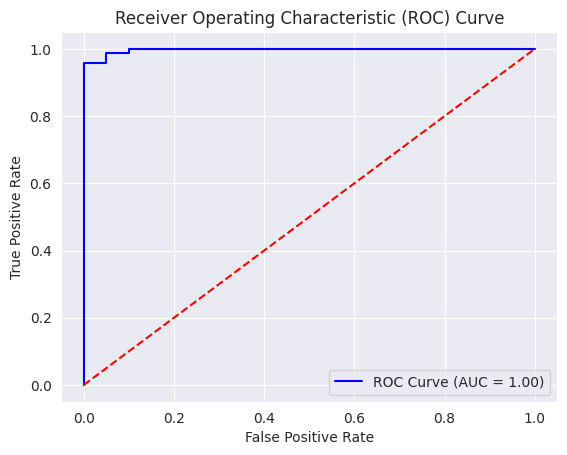

In [ ]:
# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Implentation of Log Loss

In [ ]:
def calculate_log_loss(y_true, y_pred):

    epsilon = 1e-15  # Small value to avoid log(0)

    # Clip predicted probabilities to avoid log(0) or log(1)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Compute log loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return loss

In [ ]:
print("Log Loss: " + str(calculate_log_loss(Y_test, Y_pred)))

Log Loss: 1.2119149470996806


# Verifing the implemented Accuracy, Confusion Matrix, Precision, Recall, F1 Score, AUC and Log Loss using Scikit Learn Library

In [ ]:
print("Accuracy: " + str(accuracy_score(Y_test, Y_pred)))
print("Confusion Matrix: \n" + str(confusion_matrix(Y_test, Y_pred)))
print("Precision: " + str(precision_score(Y_test, Y_pred)))
print("Recall: " + str(recall_score(Y_test, Y_pred)))
print("F1 Score: " + str(f1_score(Y_test, Y_pred)))
print("AUC: " + str(roc_auc_score(Y_test, Y_proba)))
print("Log Loss: " + str(log_loss(Y_test, Y_pred)))

Accuracy: 0.9649122807017544
Confusion Matrix: 
[[36  4]
 [ 0 74]]
Precision: 0.9487179487179487
Recall: 1.0
F1 Score: 0.9736842105263158
AUC: 0.9972972972972973
Log Loss: 1.2646895926006019


## Convert continuous features to Categorical features

In [ ]:
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
5,0,0,2,0
6,1,1,1,0
7,0,1,1,0
8,0,1,2,0
9,0,1,1,0


## Approach 2: Calculate P(X=x|Y=y) categorically

In [ ]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [ ]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

# Calculating and Returning Prediction Probability

In [ ]:
def naive_bayes_categorical_proba(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_probs = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1] * len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [likelihood[j] * prior[j] for j in range(len(labels))]

        # normalize probabilities to sum up to 1
        total_prob = sum(post_prob)
        post_prob = [prob / total_prob for prob in post_prob]

        Y_probs.append(post_prob)

    return np.array(Y_probs)

## Test Categorical model

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345


In [ ]:
Y_proba = naive_bayes_categorical_proba(train, X=X_test, Y="diagnosis")[:,1]

# Caluating Accuracy

In [ ]:
print("Accuracy: " + str(calculate_accuracy(Y_test, Y_pred)))

Accuracy: 0.9385964912280702


#Caluating Confusion Matrix

In [ ]:
print("Confusion Matrix: \n" + str(calculate_confusion_matrix(Y_test, Y_pred)))

Confusion Matrix: 
[[38  2]
 [ 5 69]]


# Calculating Precision

In [ ]:
print("Precision: " + str(calculate_precision(Y_test, Y_pred)))

Precision: 0.971830985915493


# Calculating Recall

In [ ]:
print("Recall: " + str(calculate_recall(Y_test, Y_pred)))

Recall: 0.9324324324324325


# Calculating F1 Score

In [ ]:
print("F1 Score: " + str(calculate_f1_score(Y_test, Y_pred)))

F1 Score: 0.9517241379310345


# Calculating ROC

In [ ]:
fpr, tpr, th = calculate_roc_curve(Y_test, Y_proba)

In [ ]:
auc_score = auc(fpr, tpr)

In [ ]:
auc_score

0.9888513513513513

# Calculating AUC

In [ ]:
print("AUC: " + str(calculate_auc(Y_test, Y_proba)))

AUC: 0.9888513513513513


# Plot of ROC Curve

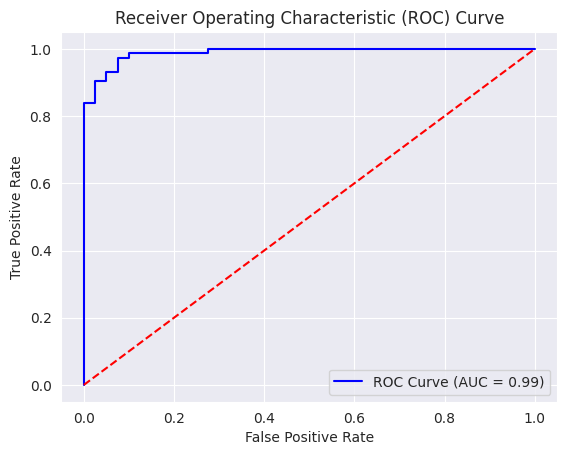

In [ ]:
# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculating Log Loss

In [ ]:
print("Log Loss: " + str(calculate_log_loss(Y_test, Y_pred)))

Log Loss: 2.1208160873617126


# Verifing the implemented Accuracy, Confusion Matrix, Precision, Recall, F1 Score, AUC and Log Loss using Scikit Learn Library

In [ ]:
print("Accuracy: " + str(accuracy_score(Y_test, Y_pred)))
print("Confusion Matrix: \n" + str(confusion_matrix(Y_test, Y_pred)))
print("Precision: " + str(precision_score(Y_test, Y_pred)))
print("Recall: " + str(recall_score(Y_test, Y_pred)))
print("F1 Score: " + str(f1_score(Y_test, Y_pred)))
print("AUC: " + str(roc_auc_score(Y_test, Y_proba)))
print("Log Loss: " + str(log_loss(Y_test, Y_pred)))

Accuracy: 0.9385964912280702
Confusion Matrix: 
[[38  2]
 [ 5 69]]
Precision: 0.971830985915493
Recall: 0.9324324324324325
F1 Score: 0.9517241379310345
AUC: 0.9842905405405405
Log Loss: 2.2132067870510532
